**Let's connect our Google Drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The FER2013 dataset directory for our model**

In [8]:
%cd drive/MyDrive/Colab Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


**Unarchieving our dataset to the folder**

In [10]:
import tarfile


fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

**Installing necessary libraries**

In [11]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot

**Data preprocessing and exploration**

In [12]:
df = pd.read_csv('fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

**Preparing the data**

In [14]:
np.array(df.pixels.loc[0].split(' ')).reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

In [15]:
img_array = df.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

In [16]:
img_array = np.stack(img_array, axis=0)

In [17]:
labels = df.emotion.values

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size =0.1)

In [19]:
X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298,), (3589,))

In [20]:
X_train = X_train/255
X_test = X_test/255

**Building the model**

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

**Model checkpoints and callbacks**

In [23]:
try:
  os.mkdir('checkpoint')

except:
  pass

In [24]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint', file_name)
call_backs = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

**Let's train our model**

In [38]:
model.fit(X_train, y_train, epochs=20, validation_split=0.1, callbacks=call_backs)

Epoch 1/20
908/909 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9967
Epoch 1: val_accuracy did not improve from 0.72508
909/909 [==============================] - 8s 9ms/step - loss: 0.0171 - accuracy: 0.9967 - val_loss: 1.5375 - val_accuracy: 0.7201
Epoch 2/20
904/909 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9966
Epoch 2: val_accuracy did not improve from 0.72508
909/909 [==============================] - 8s 9ms/step - loss: 0.0167 - accuracy: 0.9966 - val_loss: 1.6604 - val_accuracy: 0.7158
Epoch 3/20
908/909 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9964
Epoch 3: val_accuracy did not improve from 0.72508
909/909 [==============================] - 8s 8ms/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 1.6014 - val_accuracy: 0.7133
Epoch 4/20
908/909 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9964
Epoch 4: val_accuracy did not improve from 0.72508
909/909 [==========

**Now, let's test and evaluate our model**

actual label is sadness
1/1 [==============================] - 0s 19ms/step
predicted label is sadness


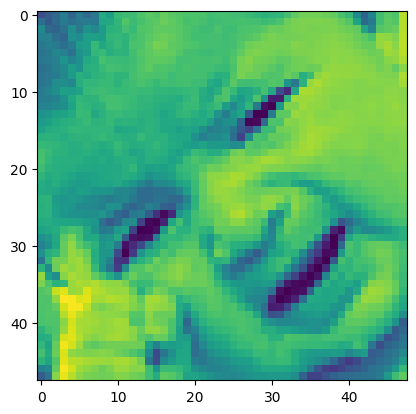

In [39]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range(40):
  print(f'actual label is {label_to_text[y_test[k]]}')
  predicted_class = model.predict(tf.expand_dims(X_test[k],0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(X_test[k].reshape((48,48)))
  pyplot.show()
  time.sleep(3)
  clear_output(wait=True)

**Adding movie.csv dataset**

In [40]:
import pandas as pd
movie_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie.csv')


**For the purpose of not running our environment again after some possible restarts let's just take our last saved best_model.h5 directly from the "drive" directory**

In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np


from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint/best_model.h5'
model = load_model(model_path)


**Implementing the movie recommendation system and testing**

<IPython.core.display.Javascript object>

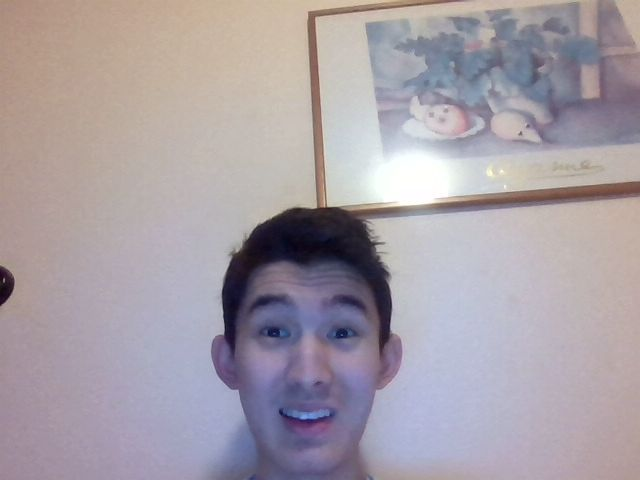

1/1 [==============================] - 0s 87ms/step
Predicted Emotion: neutral
Recommended Movies:
                                    title            genres
36          Across the Sea of Time (1995)  Documentary|IMAX
76                       Nico Icon (1995)       Documentary
97   Heidi Fleiss: Hollywood Madam (1995)       Documentary
106                        Catwalk (1996)       Documentary
114          Anne Frank Remembered (1995)       Documentary


In [46]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image, display

model = load_model('/content/drive/MyDrive/Colab Notebooks/checkpoint/best_model.h5')

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255
    return img

# Function to predict emotion
def predict_emotion(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    emotion_index = np.argmax(prediction)
    emotions = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
    return emotions[emotion_index]

def recommend_movies(emotion, movie_df):
    emotion_to_genre = {
        'anger': 'Action|Thriller',
        'disgust': 'Horror',
        'fear': 'Horror|Thriller',
        'happiness': 'Comedy|Family',
        'sadness': 'Drama',
        'surprise': 'Adventure|Sci-Fi',
        'neutral': 'Documentary'
    }
    target_genres = emotion_to_genre.get(emotion, '')
    recommended_movies = movie_df[movie_df['genres'].str.contains(target_genres)]
    return recommended_movies.head(5)

filename = take_photo()
display(Image(filename))

# Predicting the emotion
predicted_emotion = predict_emotion(filename, model)
print(f"Predicted Emotion: {predicted_emotion}")

# Recommending movies based on the emotion
recommended_movies = recommend_movies(predicted_emotion, movie_df)
print("Recommended Movies:")
print(recommended_movies[['title', 'genres']])
